# CLAUDIO RICCI

## Packages

In [1]:
import networkx as nx # For graphs
import pickle # For data parsing
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
import numpy as np

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

import warnings
from timeit import default_timer as timer
import math

import matplotlib.pyplot as plt

## Helper functions

In [2]:
def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elments 0 and -1 equal
    """
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)

def transformer_tsp(G, model, DEVICE = 'cpu'):
    """
    Evaluate your (trained) model on G
    """
    # Set the model in evaluation mode
    model.eval()

    # Note: number of edges is constant ed equal to n(n-1)/2
    n = G.number_of_nodes()
    
    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = []
    for i in range(n):
        x.append(torch.tensor(attr[i], dtype=torch.float32))

    # From list of tensors to tensor 2d
    x = torch.stack(x)    

    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    x = x.to(DEVICE).unsqueeze(0)
    y = y.to(DEVICE).unsqueeze(0)
    
    # Predict the next node
    out = transformer_model(x, y)
    
    # Loop until the tour is complete
    while len(tour) < n:
        _, idx = torch.topk(out, n, dim=2)
        for i in range(n):
            # Check if the node is already in the tour
            if idx[0, 0, i] not in tour:
                tour.append(idx[0, 0, i])
                break
        y = torch.tensor(tour)
        y = y.to(DEVICE).unsqueeze(0)
        out = transformer_model(x, y)
    
    tour = [int(i) for i in tour] + [0] # Append the starting node (that is hard-coded to 0)
    return tour_length(G, tour)



def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """

        
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf') # In case you just train with GA
        
    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf') # In case you just train without GA
    return gaps    
    

## Dataset & Dataloader

In [3]:
# Load the dummy dataset, get a single data item and explain its Python type
# with open('/kaggle/input/tspinstances/dummy_20_DLL_ass4.pkl', 'rb') as file:
#    dummy = pickle.load(file)

with open('/kaggle/input/tspinstances/train_20_DLL_ass4.pkl', 'rb') as file:
    train = pickle.load(file)

print(type(train)) # list
print('Type of a element of the dataset: ', type(train[0]))  # The type of the first object -> tuple
print('Type of the first item of the tuple: ', type(train[0][0]))  # The type of the first item of a tuple -> Graph
print('Type of the second item of the tuple: ', type(train[0][1]))  # The type of the first item of a tuple -> list
print(train[0])

<class 'list'>
Type of a element of the dataset:  <class 'tuple'>
Type of the first item of the tuple:  <class 'networkx.classes.graph.Graph'>
Type of the second item of the tuple:  <class 'list'>
(<networkx.classes.graph.Graph object at 0x7ff8c05b8fa0>, [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0])


In [4]:
train[0][0].edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (7, 8), (7, 9), (7, 10),

In [5]:
# Describe the edge attributes tour and weight

# Extract the graph and tour
graph = train[0][0]  # The networkx Graph object
tour = train[0][1]   # The tour as a list of nodes

# Inspect edges with attributes
# print("Edges and attributes:")
# for u, v, data in graph.edges(data=True):
#     print(f"  Edge ({u}, {v}):")
#     print('     Weight: ', {data.get('weight', 'Not found')})
#     print('     Tour: ',{data.get('tour', 'Not found')})

In [6]:
# Inspect the node attribute pos
# print("\nNodes and attributes:")
# for node, data in graph.nodes(data=True):
#     print(f"  Node {node}:")
#     print('     Position: ',{data.get('pos', 'Not found')})

In [7]:
# # Analyze the tour
# print("\nTour edges:")
# tour_edges = [(tour[i], tour[i+1]) for i in range(len(tour) - 1)]
# for u, v in tour_edges:
#     if graph.has_edge(u, v):
#         print(f"   Edge ({u}, {v}) exists with weight {graph[u][v].get('weight', 'Not found')}.")
#     else:
#         print(f"   Edge ({u}, {v}) does not exist in the graph.")

In [8]:
torch.manual_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [9]:
# Implement a dataset class. Focus on the getitem method to return:
# – X: A tensor of node coordinates with size 20 × 2.
# – y: A tour starting from 0 and ending with 0.

class GraphDataset(Dataset):
    def __init__(self, data):
        """
        A list of tuples where each tuple contains:
        - A networkx.Graph object
        - A tour (list of node indices)
        """
        self.data = data

    def __len__(self):
        """
        Number of instances in the dataset
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
        - X: A tensor of node coordinates with size 20 × 2.
        - y: A tensor representing the tour, starting and ending at 0.
        """
        # Extract the graph and tour
        graph, tour = self.data[idx]

        # Get node positions as a 2D array
        pos = nx.get_node_attributes(graph, 'pos')  # Dictionary {node: (x, y)}
        if not pos:
            raise ValueError(f"Graph at index {idx} is missing node positions ('pos').")

        # Ensure nodes are sorted by their index (important for consistent tensor order)
        sorted_positions = [pos[node] for node in sorted(graph.nodes())]
        
        # Convert positions to a tensor of shape (20, 2)
        X = torch.tensor(sorted_positions, dtype=torch.float32)

        # Convert the tour to a tensor
        y = torch.tensor(tour, dtype=torch.long)

        return X, y

In [10]:
# Dummy
# Create Dataset objects for training, validation, and testing, along with their respective Dataloader
# dataset = GraphDataset(dummy)
# train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

# batch_size = 32

# trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
#with open('/kaggle/input/tspinstances/train_20_DLL_ass4.pkl', 'rb') as file:
#    train = pickle.load(file)

with open('/kaggle/input/tspinstances/test_20_DLL_ass4.pkl', 'rb') as file:
    test = pickle.load(file)

with open('/kaggle/input/tspinstances/valid_20_DLL_ass4.pkl', 'rb') as file:
    valid = pickle.load(file)

batch_size = 32

train_dataset = GraphDataset(train)
val_dataset = GraphDataset(valid)
test_dataset = GraphDataset(test)

trainloader = DataLoader(train_dataset, batch_size=batch_size)
valloader = DataLoader(val_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self,emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        pos_embedding = torch.zeros((maxlen, emb_size))
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)   
        
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# n = 20
# n_enc = 4
# n_dec = 4
# de = 32
# dd = 32
# N_HEAD = 8
# DROPOUT = 0.1

class TSPTransformer(nn.Module):
    def __init__(self, n, num_encoder, num_decoder, de, dd, n_head, dropout, dim_feedforward=1024):
        super().__init__()
        # Encoder
        self.linear1 = nn.Linear(2, de)
        encoder_layer = nn.TransformerEncoderLayer(d_model=de, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True) # d_model (int) – the number of expected features in the input (required).
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder) # stack of n encoder layers
        self.linear2 = nn.Linear(de, dd)
        
        # Decoder
        self.embedding = nn.Embedding(n, dd)
        self.posEncoding = PositionalEncoding(dd, dropout)
        decoder_layer = nn.TransformerDecoderLayer(d_model=dd, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder)
        self.ffnn = nn.Linear(dd, n)

    
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor):

        
        # Encoding
        src = self.linear1(src)
        # Change: No mask for the encoder or an additive mask of zeros
        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)
        src = self.linear2(src)

        # Decoding
        trg = self.embedding(trg)
        trg = self.posEncoding(trg)
        output = self.decoder(trg, src, tgt_mask=tgt_mask, memory_mask=None,
                            tgt_key_padding_mask=tgt_padding_mask,
                            memory_key_padding_mask=src_padding_mask)
        output = self.ffnn(output)
        return output

In [13]:
def generate_square_subsequent_mask(sequence_length: int) -> Tensor:
    mask = (torch.triu(torch.ones((sequence_length, sequence_length), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt, DEVICE):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = torch.zeros((src.shape[0], src_seq_len), device=DEVICE).bool() # Corrected
    tgt_padding_mask = torch.zeros((tgt.shape[0], tgt_seq_len), device=DEVICE).bool() # Corrected

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

$n$ = num di nodes -> Each TSP instance has exactly 20 nodes, and the input consists of their 2D coordinates.

$de$ = size of the internal rapresentation of the input coordinates
       2 feature per node -> small values like 16, 32, 64

$dd$ = size of intermediate representation
     y is a sequence of discrete node indeces, typical equal to de but also higher

$Ne$ = num encoeer layers -> 2,4,6

$Nd$ = num decoder layers -> equal to Ne but also higher

In [14]:
# d_e=512, d_d=512, num_encoder_layers=6
# num_decoder_layers=6, dropout=0.2
n = 20
n_enc = 6
n_dec = 6
de = 128
dd = 128
N_HEAD = 8
DROPOUT = 0.3
dim_feedforward=1024 #(se non specificato 1024 in mio modello)

TSPmodel = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)

## Training

### Training WITHOUT gradient accumulation

In [15]:
# Function for training a single epoch
def train_epoch(model, optimizer, trainloader, loss_fn, DEVICE):
    model.train()
    losses = 0

    for src, tgt in trainloader:
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        optimizer.zero_grad()

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)
        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        # gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()
        losses += loss.item()

    return losses / len(trainloader)

In [16]:
# Function for evaluation
def evaluate(model, valloader, loss_fn, DEVICE, num_heads):
    model.eval()
    losses = 0

    with torch.no_grad():
        for src, tgt in valloader:
            src = src.to(DEVICE)  # Node coordinates (input to the encoder)
            tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)
          
            tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
            tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

            # Generate masks for attention
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

            # Forward pass
            output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

            loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()

    avg_loss = losses / len(valloader)
    return avg_loss

In [17]:
warnings.filterwarnings("ignore")

# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(TSPmodel.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Training configuration
NUM_EPOCHS = 15
train_losses = []
val_losses = []
counter = 0

best_epoch = 0
print_every = 3
best_val_loss = float('inf')

start_tot_time = timer()
# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    
    # Train for one epoch
    train_loss = train_epoch(TSPmodel, optimizer, trainloader, loss_fn, DEVICE)    
    
    # Evaluate on validation data
    val_loss = evaluate(TSPmodel, valloader, loss_fn, DEVICE, N_HEAD)
    end_time = timer()

    if best_val_loss < val_loss:
        counter += 1
    else:
        counter = 0
        best_val_loss = val_loss
        # save the best model
        torch.save({
                'epoch': epoch,
                'model_state_dict': TSPmodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'best_model.pt')
        best_epoch = epoch

    # Log losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_tot_time = timer() - start_tot_time

    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
        print(f"Epoch time = {(end_time - start_time):.3f}s")
    
    if counter == 5:
        print(f'Overfitting at epoch {epoch}')
        break
    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

print(f'Training time: {end_tot_time/60} minuti')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_losses[best_epoch-1]:.3f} and evaluation loss of {best_val_loss:.3f}")

Epoch: 3
Train loss: 2.018, Val loss: 1.996
Epoch time = 61.118s
Epoch: 6
Train loss: 1.995, Val loss: 1.986
Epoch time = 62.179s
Epoch: 9
Train loss: 1.986, Val loss: 1.985
Epoch time = 61.960s
Reached ten minutes of training without overfitting at epoch 10
Training time: 10.392186996899998 minuti
The best model is obtained at epoch 7 with a training loss of 1.991 and evaluation loss of 1.984


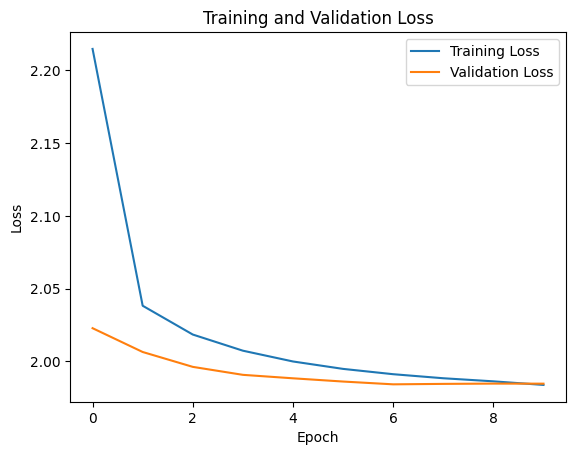

[2.2146573902625573, 2.0382529976119312, 2.0184749207737656, 2.007382700478352, 1.9999737590837388, 1.9948791696410566, 1.9912316653489, 1.9884528027691295, 1.9863329944287214, 1.983869307176928] [2.0228377878665924, 2.0064873434603214, 1.9962707497179508, 1.990795075893402, 1.9884143322706223, 1.9861884415149689, 1.984275195747614, 1.9845802336931229, 1.9847759939730167, 1.9847339428961277]


In [18]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print(train_losses, val_losses)

### Training WITH gradient accumulation

In [19]:
def train_epoch_acc(model, optimizer, trainloader, loss_fn, DEVICE, accum_iter=4):
    model.train()
    losses = 0
    optimizer.zero_grad()

    for batch_idx, (src, tgt) in enumerate(trainloader):
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Tour indices (target sequence for the decoder)

        tgt_input = tgt[:, :-1]  # Input to the decoder (shifted by one token)
        tgt_out = tgt[:, 1:]  # Target for loss computation (shifted by one token)

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        # Forward pass
        output = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
        
        # Compute the loss divided by accum_iter for gradient accumulation
        loss = loss_fn(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1)) / accum_iter
        loss.backward()

        if (batch_idx + 1) % accum_iter == 0 or (batch_idx + 1 == len(trainloader)):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional: Gradient clipping
            optimizer.step()
            optimizer.zero_grad()

        # Accumulate the actual (unscaled) loss for logging
        losses += loss.item() * accum_iter

    return losses / len(trainloader)

In [20]:
warnings.filterwarnings("ignore")

# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(TSPmodel.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

# Training configuration
NUM_EPOCHS = 15
train_losses = []
val_losses = []
counter = 0

best_epoch = 0
print_every = 3
best_val_loss = float('inf')

start_tot_time = timer()
# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    
    # Train for one epoch
    train_loss = train_epoch_acc(TSPmodel, optimizer, trainloader, loss_fn, DEVICE)    
    
    # Evaluate on validation data
    val_loss = evaluate(TSPmodel, valloader, loss_fn, DEVICE, N_HEAD)
    end_time = timer()

    if best_val_loss < val_loss:
        counter += 1
    else:
        counter = 0
        best_val_loss = val_loss
        # save the best model
        torch.save({
                'epoch': epoch,
                'model_state_dict': TSPmodel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'best_model.pt')
        best_epoch = epoch

    # Log losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_tot_time = timer() - start_tot_time

    if epoch % print_every == 0:
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")
        print(f"Epoch time = {(end_time - start_time):.3f}s")
    
    if counter == 5:
        print(f'Overfitting at epoch {epoch}')
        break
    elif end_tot_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

print(f'Training time: {end_tot_time/60} minuti')
print(f"The best model is obtained at epoch {best_epoch} with a training loss of {train_losses[best_epoch-1]} and evaluation loss of {best_val_loss}")

Epoch: 3
Train loss: 1.972, Val loss: 1.982
Epoch time = 57.524s
Epoch: 6
Train loss: 1.968, Val loss: 1.984
Epoch time = 56.956s
Overfitting at epoch 6
Training time: 5.736049649266666 minuti
The best model is obtained at epoch 1 with a training loss of 1.9763812139411043 and evaluation loss of 1.9812249019742012


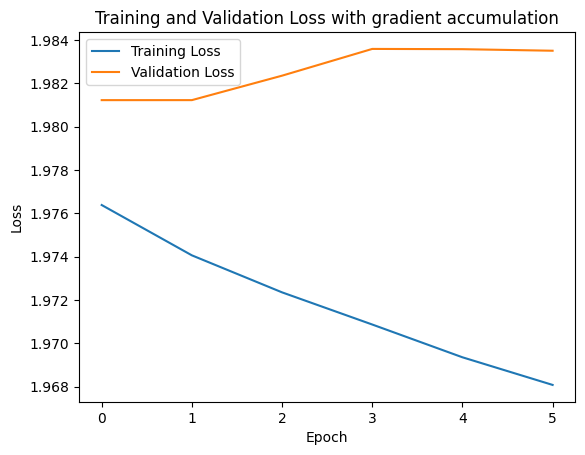

[1.9763812139411043, 1.974057346296402, 1.9723479345831747, 1.9708629221162655, 1.9693495774223342, 1.9680733438187963] [1.9812249019742012, 1.9812253303825855, 1.9823545813560486, 1.983590044081211, 1.9835783168673515, 1.9835063442587852]


In [21]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with gradient accumulation')
plt.legend()
plt.show()

print(train_losses, val_losses)

## Testing